### 📚 Bayesian Sequential Update for Linear Regression — Step-by-Step Explanation

We use Bayesian linear regression to learn a distribution over model parameters instead of a single best-fit solution. This allows us to represent **uncertainty** in our predictions and update our beliefs as new data arrives **sequentially**.

---

### 🧠 What We're Doing

We model the target as:
\[
t_n = \phi(x_n)^\top \mathbf{w} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
\]

Instead of solving for a single weight vector \( \mathbf{w} \), we maintain a **posterior distribution** over weights that gets updated with every new data point.

---

### 🔧 Step-by-Step Breakdown

#### 🟩 1. Prior over weights

We begin with a Gaussian prior:
\[
p(\mathbf{w}) = \mathcal{N}(\mathbf{w} \mid \mathbf{m}_0, \mathbf{S}_0)
\]

Typically:
- \( \mathbf{m}_0 = \mathbf{0} \)
- \( \mathbf{S}_0 = \mathbf{I} \)

This represents our **initial belief**: weights are independent with unit variance.

---

#### 🟩 2. Likelihood from a single data point

Given one data point \( (x_n, t_n) \), the likelihood is:
\[
p(t_n \mid \mathbf{w}) = \mathcal{N}(t_n \mid \phi(x_n)^\top \mathbf{w}, \sigma^2)
\]

This models how likely the observed output is for a given weight vector \( \mathbf{w} \).

---

#### 🟩 3. Bayes’ Rule for Posterior

Using Bayes' rule, we update our belief:
\[
p(\mathbf{w} \mid \mathcal{D}_n) \propto p(\mathbf{w}) \cdot \prod_{i=1}^n p(t_i \mid \mathbf{w})
\]

Instead of recomputing from scratch, we **sequentially update**:
- \( \mathbf{m}_n \): posterior mean of weights
- \( \mathbf{S}_n \): posterior covariance

---

### ✅ Posterior Update Equations

After observing \( n \) data points, we update the posterior:

\[
\mathbf{S}_n^{-1} = \mathbf{S}_{n-1}^{-1} + \frac{1}{\sigma^2} \phi(x_n)\phi(x_n)^\top
\]

\[
\mathbf{m}_n = \mathbf{S}_n \left( \mathbf{S}_{n-1}^{-1} \mathbf{m}_


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# True function
def true_func(x):
    return np.sin(2 * np.pi * x)

# Generate 100 points uniformly in [0, 1]
x = np.linspace(0, 1, 100)
x = x.reshape(-1,1)
t = (true_func(x) + np.random.normal(0, 0.1, size=x.shape)).flatten() # noise std = 0.1


In [3]:
def gaussian_basis_function(x, mu, s_param):
    return np.exp(-0.5 * ((x - mu) / s_param) ** 2)

# Choose 20 basis functions with centers evenly spaced in [0,1]
M = 20
centers = np.linspace(0, 1, M)
centers = centers.reshape(1,-1)
sigma = 0.05  # width of each Gaussian
Phi = gaussian_basis_function(x, centers, sigma)


In [4]:
######################################
# Functions for Fitting and Prediction
######################################

def fit_regularized_least_squares(phi_matrix, t_vector, lambda_reg):
    M_params = phi_matrix.shape[1]
    identity_matrix = np.identity(M_params)
    A = phi_matrix.T @ phi_matrix + lambda_reg * identity_matrix
    b = phi_matrix.T @ t_vector
    try:
        weights = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print(
            f"Warning: Singular matrix encountered with lambda={lambda_reg}.\n"
            f"Using pseudo-inverse."
        )
        weights = np.linalg.pinv(A) @ b
    return weights

def predict(phi_matrix, weights):
    return phi_matrix @ weights

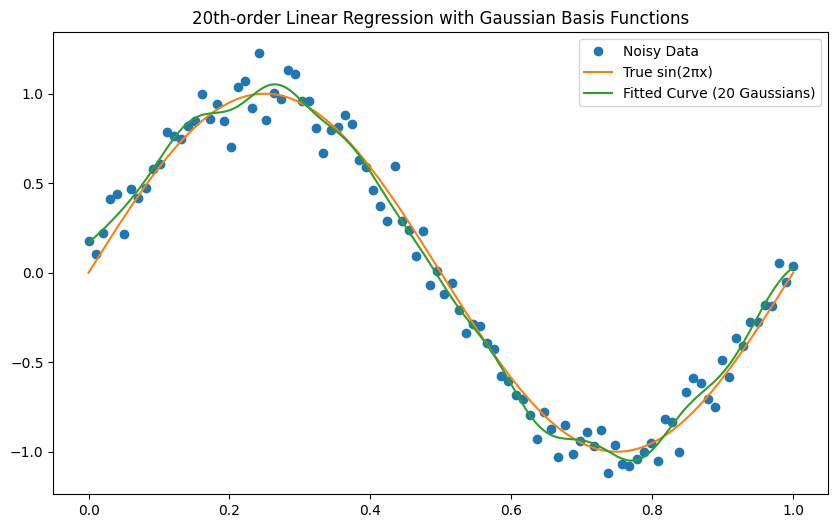

In [5]:
# Predict
lamda = 0.01
x_test = np.linspace(0, 1, 1000)
x_test = x_test.reshape(-1,1)
w = fit_regularized_least_squares(Phi,t,lamda)
Phi_test = gaussian_basis_function(x_test, centers, sigma)
y_pred = Phi_test @ w

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, t, 'o', label='Noisy Data')
plt.plot(x_test, true_func(x_test), label='True sin(2πx)')
plt.plot(x_test, y_pred, label='Fitted Curve (20 Gaussians)')
plt.legend()
plt.title('20th-order Linear Regression with Gaussian Basis Functions')
plt.show()


In [6]:
def bayesian_update(prior_mean, prior_cov, phi_x, t_val, sigma2):
    """
    Update the posterior mean and covariance with a new (phi_x, t_val) pair.
    """
    phi_x = phi_x.reshape(-1, 1)  # Ensure column vector
    S_inv = np.linalg.inv(prior_cov)
    
    # Update posterior covariance
    S_new_inv = S_inv + (1 / sigma2) * (phi_x @ phi_x.T)
    S_new = np.linalg.inv(S_new_inv)
    
    # Update posterior mean
    m_new = S_new @ (S_inv @ prior_mean + (1 / sigma2) * phi_x.flatten() * t_val)
    
    return m_new, S_new


In [7]:
D = Phi.shape[1]           # Number of basis functions
sigma2 = 0.01              # Known noise variance (σ²)
m_prior = np.zeros(D)      # Prior mean: zero vector
S_prior = np.eye(D)        # Prior covariance: identity matrix
m_N, S_N = m_prior.copy(), S_prior.copy()  # Start with prior

for i in range(Phi.shape[0]):  # Loop through training examples
    phi_xi = Phi[i]      # Row i from design matrix
    t_i = t[i]           # Corresponding target value
    m_N, S_N = bayesian_update(m_N, S_N, phi_xi, t_i, sigma2)


In [8]:
n_samples = 100
sampled_curves = []

for _ in range(n_samples):
    w_sample = np.random.multivariate_normal(mean=m_N, cov=S_N)
    y_sample = predict(Phi_test, w_sample)
    sampled_curves.append(y_sample)

sampled_curves = np.array(sampled_curves)
average_curve = np.mean(sampled_curves, axis=0)


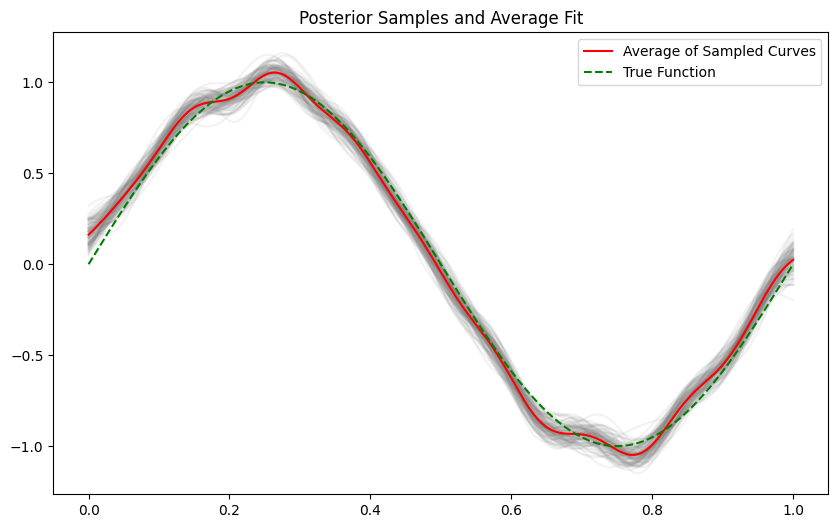

In [9]:
plt.figure(figsize=(10, 6))
for i in range(n_samples):
    plt.plot(x_test, sampled_curves[i], color='gray', alpha=0.1)

plt.plot(x_test, average_curve, label='Average of Sampled Curves', color='red')
plt.plot(x_test, true_func(x_test), label='True Function', linestyle='--', color='green')
plt.legend()
plt.title("Posterior Samples and Average Fit")
plt.show()


In [10]:
mu_preds = []
std_preds = []
noise_variance = 0.01

for phi_x0 in Phi_test:  # loop over test design matrix rows
    phi_x0 = phi_x0.reshape(-1, 1)
    mu = (phi_x0.T @ m_N).item()
    sigma2 = (phi_x0.T @ S_N @ phi_x0).item() + noise_variance
    mu_preds.append(mu)
    std_preds.append(np.sqrt(sigma2))


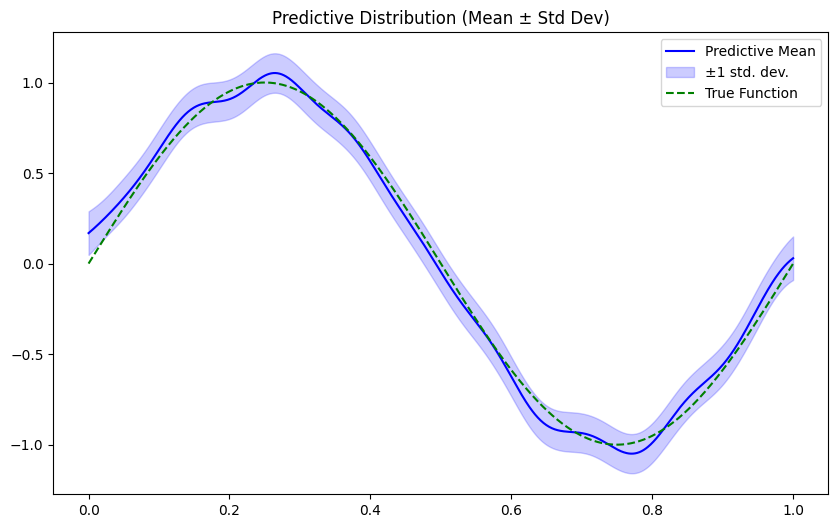

In [11]:
mu_preds = np.array(mu_preds)
std_preds = np.array(std_preds)

plt.figure(figsize=(10,6))
plt.plot(x_test, mu_preds, label="Predictive Mean", color='blue')
plt.fill_between(x_test.flatten(), mu_preds - std_preds, mu_preds + std_preds,
                 color='blue', alpha=0.2, label="±1 std. dev.")
plt.plot(x_test, true_func(x_test), label="True Function", linestyle='--', color='green')
plt.legend()
plt.title("Predictive Distribution (Mean ± Std Dev)")
plt.show()



--- Predictive Distribution Using First 2 Data Points ---


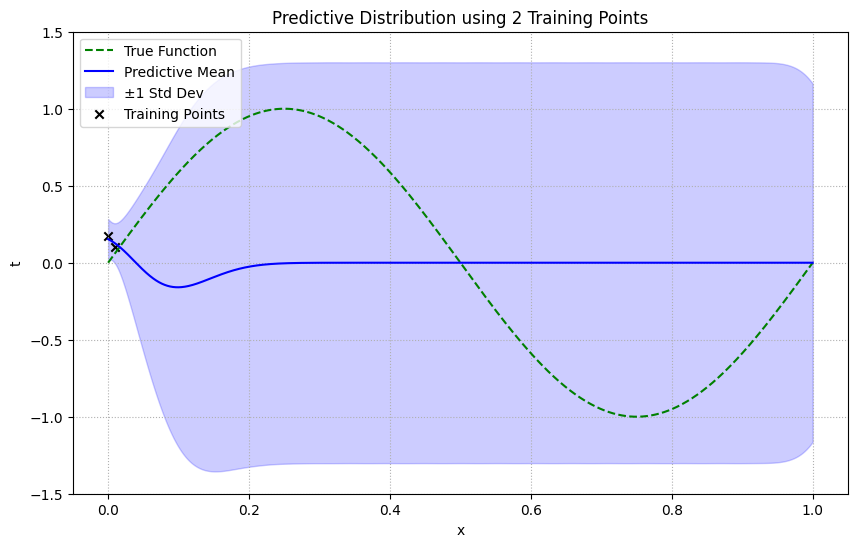


--- Predictive Distribution Using First 5 Data Points ---


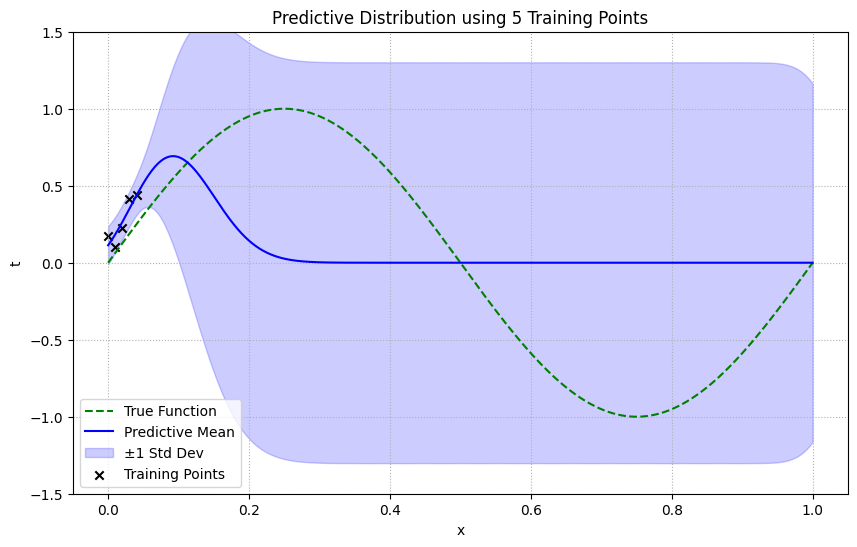


--- Predictive Distribution Using First 10 Data Points ---


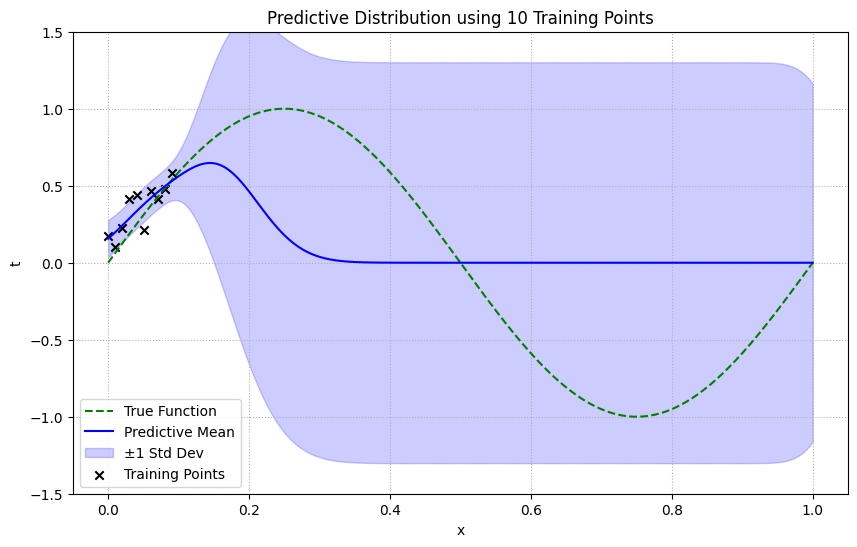


--- Predictive Distribution Using First 25 Data Points ---


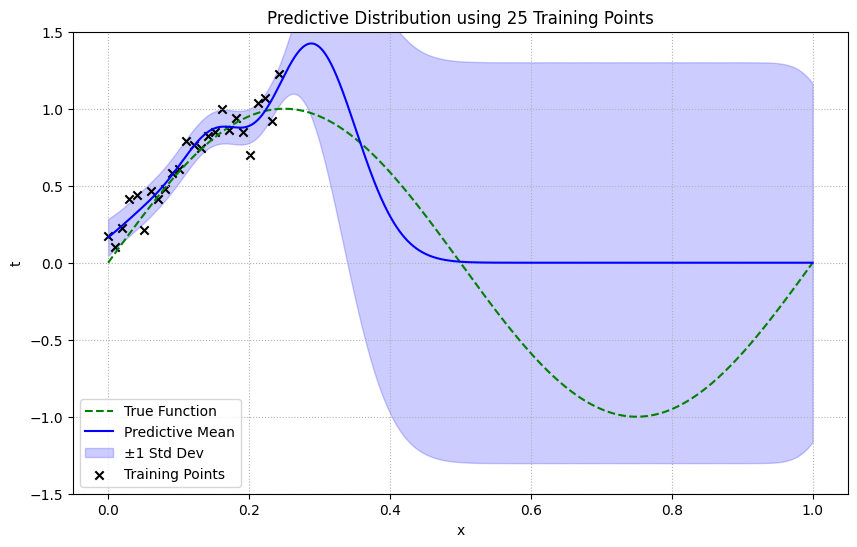


--- Predictive Distribution Using First 50 Data Points ---


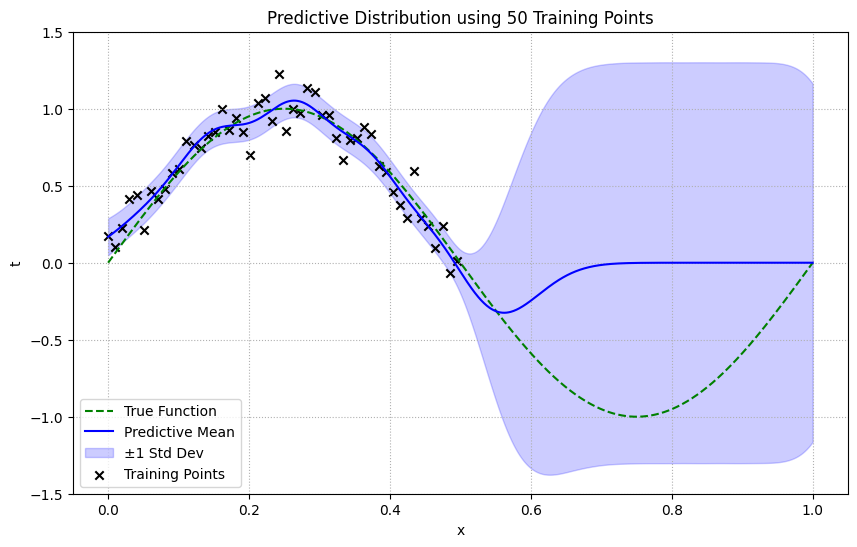

In [ ]:
# Training sizes to experiment with
training_sizes = [2, 5, 10, 25]
sigma2 = 0.01  # Noise variance
noise_std = np.sqrt(sigma2)

for n_train in training_sizes:
    print(f"\n--- Predictive Distribution Using First {n_train} Data Points ---")
    
    # Slice first n_train points from training set
    Phi_subset = Phi[:n_train]
    t_subset = t[:n_train]

    # Initialize prior
    D = Phi.shape[1]
    m_N = np.zeros(D)
    S_N = np.eye(D)

    # Sequential Bayesian update
    for i in range(n_train):
        phi_xi = Phi_subset[i]
        t_i = t_subset[i]
        m_N, S_N = bayesian_update(m_N, S_N, phi_xi, t_i, sigma2)

    # Predictive mean and std for test set
    mu_preds = []
    std_preds = []

    for phi_x0 in Phi_test:
        phi_x0 = phi_x0.reshape(-1, 1)
        mu = (phi_x0.T @ m_N).item()
        pred_var = (phi_x0.T @ S_N @ phi_x0).item() + sigma2
        mu_preds.append(mu)
        std_preds.append(np.sqrt(pred_var))

    mu_preds = np.array(mu_preds)
    std_preds = np.array(std_preds)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_test, true_func(x_test), 'g--', label='True Function')
    plt.plot(x_test, mu_preds, 'b', label='Predictive Mean')
    plt.fill_between(x_test.flatten(),
                     mu_preds - std_preds,
                     mu_preds + std_preds,
                     color='blue', alpha=0.2, label='±1 Std Dev')

    plt.scatter(x[:n_train], t[:n_train], color='black', marker='x', label='Training Points')
    plt.title(f"Predictive Distribution using {n_train} Training Points")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(-1.5, 1.5)
    plt.show()
